In [1]:
import torch
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from UNet import UNet, UNetWithAttention

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Crea istanza modello (deve avere la stessa architettura usata in training)
model = UNetWithAttention(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))
model.to(device)
model.eval()  # modalità valutazione (disabilita dropout, batchnorm, ecc)

UNetWithAttention(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(i

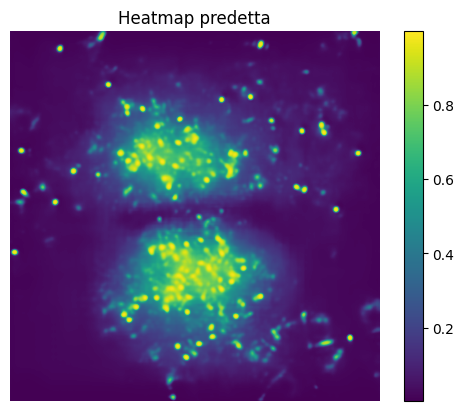

(800, 800)
Min: 0.0032249528
Max: 0.9970024
Mean: 0.15858807
[[0.02544895 0.01776654 0.0123353  ... 0.00789267 0.01193454 0.01906723]
 [0.02259281 0.01841175 0.01373181 ... 0.00745341 0.0115267  0.01444049]
 [0.01729655 0.0148355  0.01058524 ... 0.00736671 0.00950029 0.01094577]
 ...
 [0.01198237 0.00854076 0.00664987 ... 0.00656993 0.00873681 0.01124629]
 [0.01327899 0.01004882 0.00638582 ... 0.00645133 0.00990191 0.01195008]
 [0.01057639 0.0090837  0.0059956  ... 0.00606511 0.00881851 0.01525685]]


In [2]:
img_path = '/user/gr1/delphi/dghezzi/UNet/Models/event_92.npy'

img = np.load(img_path)  # shape atteso (H, W)
img = img.astype(np.float32)  # assicurati che sia in float32
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img_tensor)  # shape attesa (1, 1, H, W)
    outputs = torch.sigmoid(outputs)  # applica sigmoid per ottenere valori tra 0 e 1

outputs = outputs.squeeze(0).squeeze(0).cpu().numpy()  # rimuovi dimensioni non necessarie

plt.imshow(outputs)
plt.title("Heatmap predetta")
plt.colorbar()
plt.axis('off')
plt.show()
plt.imsave("heatmap_predetta.png", outputs)

print(outputs.shape)
print("Min:", outputs.min())
print("Max:", outputs.max())
print("Mean:", outputs.mean())
print(outputs)

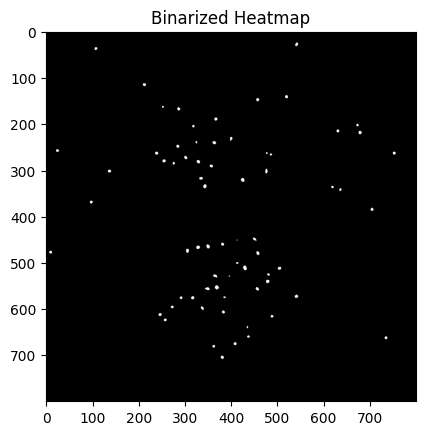

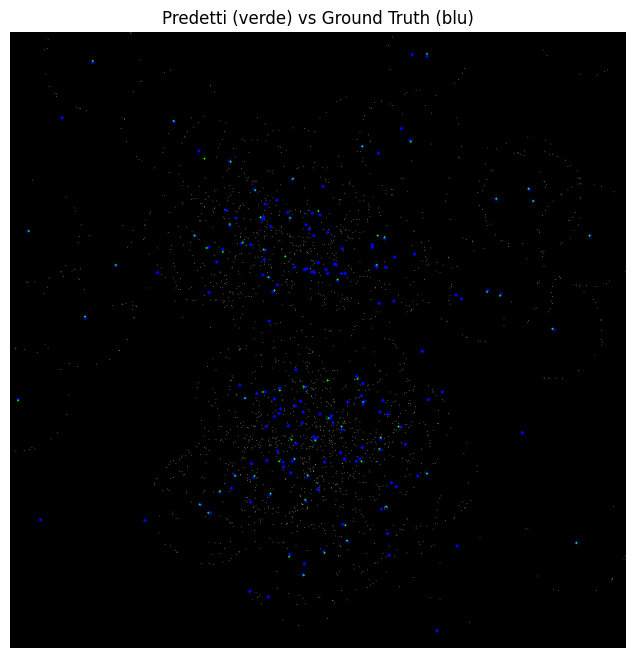

Threshold in pixels: 4 ==> precision: 0.8841, recall: 0.3547, f1-score: 0.5062


In [3]:
from UNet import infer_keypoints_from_image, img_kp_pred_and_gr, compute_pck_metrics, load_keypoints_from_csv

heatmap, keypoints, time = infer_keypoints_from_image(img_path, model, device=device, show_mask=True, threshold=0.97, npy=True, sigmoid=True)

keypoints_gt = load_keypoints_from_csv('/user/gr1/delphi/dghezzi/UNet/Models/event_92_centers.csv')
img_kp_pred_and_gr(keypoints_pred=keypoints, keypoints_gt=keypoints_gt, img_path=img_path)
pck_metrics = compute_pck_metrics(keypoints_gt, keypoints, thresholds=[4])
print(f'Threshold in pixels: 4 ==> precision: {pck_metrics[0][0]:.4f}, recall: {pck_metrics[1][0]:.4f}, f1-score: {pck_metrics[2][0]:.4f}')

In [4]:
coeff_bin_thresholds = np.arange(0.92, 1.00, 0.001)
f1_2px = []
f1_4px = []
f1_6px = []

for i in coeff_bin_thresholds:
    heatmap, keypoints, time = infer_keypoints_from_image(img_path, model, device=device, show_mask=False, threshold=i, npy=True, sigmoid=True)
    #img_kp_pred_and_gr(keypoints_pred=keypoints, keypoints_gt=keypoints_gt, img_path=img_path)
    prec, recall, f1 = compute_pck_metrics(keypoints_gt, keypoints, thresholds=[2,4,6])
    f1_2px.append(f1[0])
    f1_4px.append(f1[1])
    f1_6px.append(f1[2])
    print(f"Coefficient Binary Threshold: {i:.2f}")
    print(f"keypoints predicted: {len(keypoints)}, keypoints ground truth: {len(keypoints_gt)}, ratio: {len(keypoints)/len(keypoints_gt):.2f}")
    print(f"Metrics Threshold 2px: prec = {prec[0]:.3f}, recall = {recall[0]:.3f}, f1 = {f1[0]:.3f}")
    print(f"Metrics Threshold 4px: prec = {prec[1]:.3f}, recall = {recall[1]:.3f}, f1 = {f1[1]:.3f}")
    print(f"Metrics Threshold 6px: prec = {prec[2]:.3f}, recall = {recall[2]:.3f}, f1 = {f1[2]:.3f}")
    print('')

Coefficient Binary Threshold: 0.92
keypoints predicted: 95, keypoints ground truth: 172, ratio: 0.55
Metrics Threshold 2px: prec = 0.305, recall = 0.169, f1 = 0.217
Metrics Threshold 4px: prec = 0.663, recall = 0.366, f1 = 0.472
Metrics Threshold 6px: prec = 0.737, recall = 0.407, f1 = 0.524

Coefficient Binary Threshold: 0.92
keypoints predicted: 94, keypoints ground truth: 172, ratio: 0.55
Metrics Threshold 2px: prec = 0.309, recall = 0.169, f1 = 0.218
Metrics Threshold 4px: prec = 0.660, recall = 0.360, f1 = 0.466
Metrics Threshold 6px: prec = 0.734, recall = 0.401, f1 = 0.519

Coefficient Binary Threshold: 0.92
keypoints predicted: 94, keypoints ground truth: 172, ratio: 0.55
Metrics Threshold 2px: prec = 0.309, recall = 0.169, f1 = 0.218
Metrics Threshold 4px: prec = 0.660, recall = 0.360, f1 = 0.466
Metrics Threshold 6px: prec = 0.734, recall = 0.401, f1 = 0.519

Coefficient Binary Threshold: 0.92
keypoints predicted: 94, keypoints ground truth: 172, ratio: 0.55
Metrics Threshold

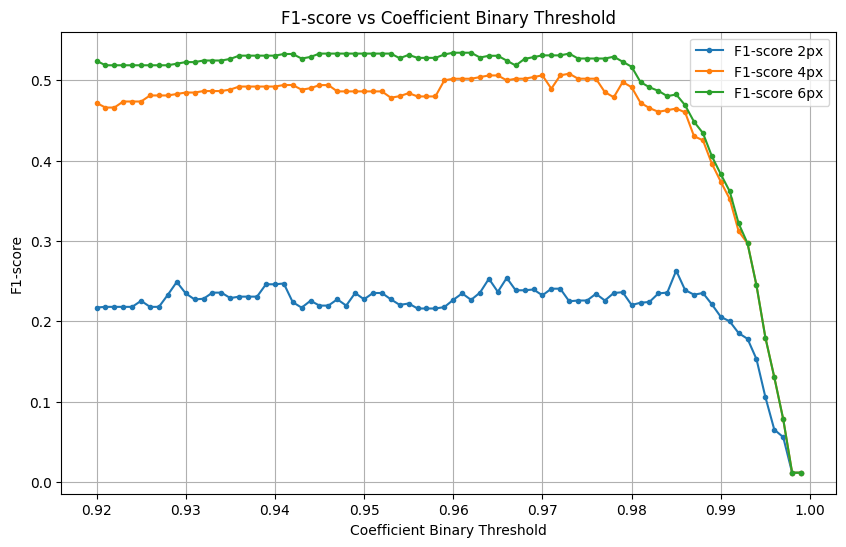

In [7]:
# grafico delle f1-score
plt.figure(figsize=(10, 6))
plt.plot(coeff_bin_thresholds, f1_2px, label='F1-score 2px', marker='.')
plt.plot(coeff_bin_thresholds, f1_4px, label='F1-score 4px', marker='.')
plt.plot(coeff_bin_thresholds, f1_6px, label='F1-score 6px', marker='.')
plt.title('F1-score vs Coefficient Binary Threshold')
plt.xlabel('Coefficient Binary Threshold')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
plt.savefig("f1_scores_vs_threshold.png")
plt.show()

0.97 sembra essere il valore migliore di threshold per la maschera binaria

In [13]:
from UNet import inference_dataset

# Esegui inferenza su un intero dataset
dataset_path = '/user/gr1/delphi/dghezzi/UNet/UNet_dataset/500test_npy'
model_path = '/user/gr1/delphi/dghezzi/UNet/Models/Model_22500_2500_160_180_npy/best_unet.pth'
output_dir = '/user/gr1/delphi/dghezzi/UNet/Models/Model_22500_2500_160_180_npy/output_inference'

inference_dataset(dataset_path, output_dir, model_path, device=device)

{'precision': [0.4956813233971499, 0.8019533269439286, 0.884044485154997],
 'recall': [0.18852146471042638, 0.305490841166038, 0.33675882835859894],
 'f1': [0.2727070581096013, 0.441719775323534, 0.4869304834904526],
 'stdmean_f1': [0.001542270554018444,
  0.0015807743123442857,
  0.0014906268775554201],
 'inference_time': 0.004012956142425537}

In [32]:
# Variazione soglia binaria dopo sigmoid
coeff_bin_thresholds = np.arange(0.95, 0.99, 0.005)

# Per salvare risultati
f1_2px, f1_3px, f1_4px, f1_5px, f1_6px = [], [], [], [], []
stdmean_f1_2px, stdmean_f1_3px, stdmean_f1_4px, stdmean_f1_5px, stdmean_f1_6px = [], [], [], [], []

for i in coeff_bin_thresholds:
    print(f"==> Coefficient Binary Threshold: {i:.3f}")
    
    output_dir = f"{output_dir}/thresh_{i:.3f}".replace('.', '_')
    
    metrics = inference_dataset(
        datapath=dataset_path,
        output_path=output_dir,
        model_path=model_path,
        device='cuda',                      # o 'cpu'
        pixel_thresholds=[2, 3, 4, 5, 6],
        attention_model=True,              # o False, a seconda del modello
        threshold=i,                       # soglia binaria dopo sigmoid
        show_mask=False
    )

    # Estrai metriche
    f1_2px.append(metrics['f1'][0])
    stdmean_f1_2px.append(metrics['stdmean_f1'][0])
    f1_3px.append(metrics['f1'][1])
    stdmean_f1_3px.append(metrics['stdmean_f1'][1])
    f1_4px.append(metrics['f1'][2])
    stdmean_f1_4px.append(metrics['stdmean_f1'][2])
    f1_5px.append(metrics['f1'][3])
    stdmean_f1_5px.append(metrics['stdmean_f1'][3])
    f1_6px.append(metrics['f1'][4])
    stdmean_f1_6px.append(metrics['stdmean_f1'][4])

    print(f"Threshold 2px: {metrics['precision'][0]:.3f}, Recall: {metrics['recall'][0]:.3f}, F1: {metrics['f1'][0]:.3f}")
    print(f"Threshold 3px: {metrics['precision'][1]:.3f}, Recall: {metrics['recall'][1]:.3f}, F1: {metrics['f1'][1]:.3f}")
    print(f"Threshold 4px: {metrics['precision'][2]:.3f}, Recall: {metrics['recall'][2]:.3f}, F1: {metrics['f1'][2]:.3f}")
    print(f"Threshold 5px: {metrics['precision'][3]:.3f}, Recall: {metrics['recall'][3]:.3f}, F1: {metrics['f1'][3]:.3f}")
    print(f"Threshold 6px: {metrics['precision'][4]:.3f}, Recall: {metrics['recall'][4]:.3f}, F1: {metrics['f1'][4]:.3f}")

    print('')

==> Coefficient Binary Threshold: 0.950


Threshold 2px: 0.433, Recall: 0.193, F1: 0.267
Threshold 3px: 0.628, Recall: 0.280, F1: 0.387
Threshold 4px: 0.720, Recall: 0.322, F1: 0.444
Threshold 5px: 0.771, Recall: 0.344, F1: 0.475
Threshold 6px: 0.813, Recall: 0.364, F1: 0.502

==> Coefficient Binary Threshold: 0.955
Threshold 2px: 0.446, Recall: 0.193, F1: 0.269
Threshold 3px: 0.646, Recall: 0.280, F1: 0.390
Threshold 4px: 0.739, Recall: 0.320, F1: 0.446
Threshold 5px: 0.788, Recall: 0.341, F1: 0.476
Threshold 6px: 0.830, Recall: 0.360, F1: 0.501

==> Coefficient Binary Threshold: 0.960
Threshold 2px: 0.460, Recall: 0.192, F1: 0.271
Threshold 3px: 0.666, Recall: 0.278, F1: 0.392
Threshold 4px: 0.758, Recall: 0.317, F1: 0.447
Threshold 5px: 0.808, Recall: 0.338, F1: 0.476
Threshold 6px: 0.848, Recall: 0.355, F1: 0.499

==> Coefficient Binary Threshold: 0.965
Threshold 2px: 0.476, Recall: 0.191, F1: 0.272
Threshold 3px: 0.686, Recall: 0.275, F1: 0.392
Threshold 4px: 0.779, Recall: 0.313, F1: 0.446
Threshold 5px: 0.827, Recall: 0

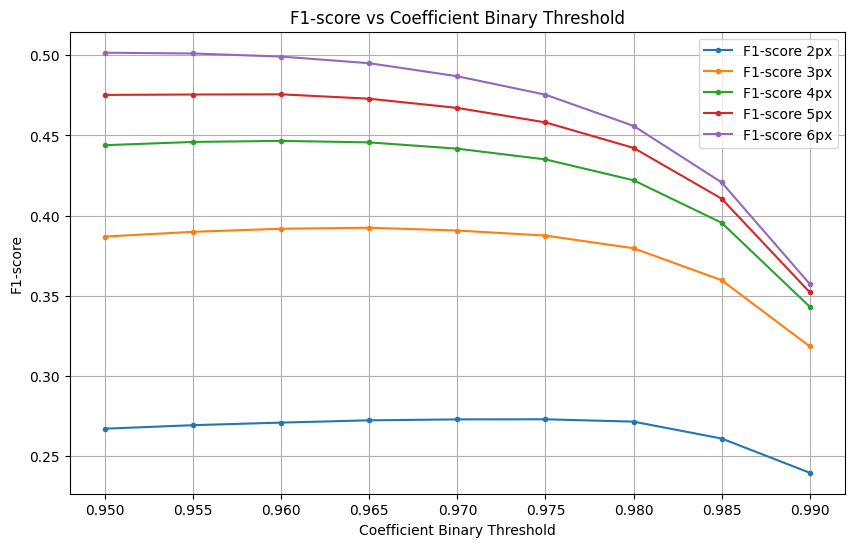

Average Inference Time: 4.10 ms


In [34]:
# grafico delle f1-score
plt.figure(figsize=(10, 6))
plt.plot(coeff_bin_thresholds, f1_2px, label='F1-score 2px', marker='.')
plt.plot(coeff_bin_thresholds, f1_3px, label='F1-score 3px', marker='.')
plt.plot(coeff_bin_thresholds, f1_4px, label='F1-score 4px', marker='.')
plt.plot(coeff_bin_thresholds, f1_5px, label='F1-score 5px', marker='.')
plt.plot(coeff_bin_thresholds, f1_6px, label='F1-score 6px', marker='.')
plt.title('F1-score vs Coefficient Binary Threshold')
plt.xlabel('Coefficient Binary Threshold')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
plt.savefig("f1_scores_vs_threshold_inference_dataset.png")
plt.show()

print(f"Average Inference Time: {np.mean(metrics['inference_time'])*1000:.2f} ms")